In [1]:
from funman.funman import Funman
from funman.scenario import ParameterSynthesisScenario
from funman.model import Parameter
from funman.scenario import ParameterSynthesisScenarioResult
from funman.parameter_space import ParameterSpace

%load_ext autoreload
%autoreload 2

# Todo
- Dan: Extend chime model with beta_2 and timesteps 20-60
- Drisana: Plot results from a scenario result (in ParameterSpace.plot())
- Drisana: box operations

In [2]:
gromet_file1 = "chime1"

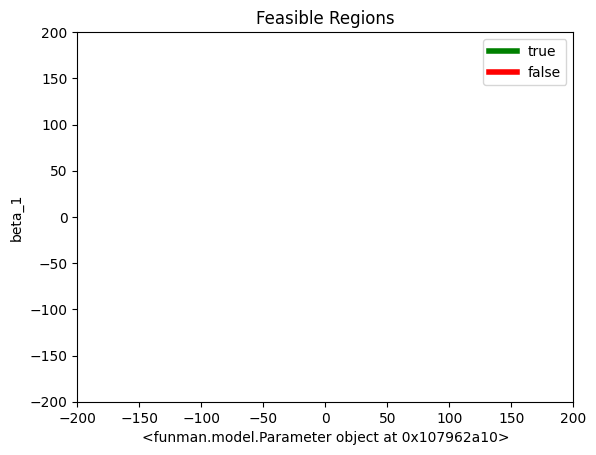

Process Process-1:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/danbryce/Documents/sift/ASKEM/code/funman/src/funman/plotting.py", line 66, in run
    box = episode.get_box_to_plot()
  File "/Users/danbryce/Documents/sift/ASKEM/code/funman/src/funman/search_episode.py", line 78, in get_box_to_plot
    return self.boxes_to_plot.get()
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/multiprocessing/queues.py", line 103, in get
    res = self._recv_bytes()
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/multiprocessing/connection.py", line 221, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/multiprocessing/connection.

KeyboardInterrupt: 

In [3]:
# TODO add description of scenario and betas

result1 : ParameterSynthesisScenarioResult = Funman().solve(
    ParameterSynthesisScenario(
        [Parameter("beta_0"), Parameter("beta_1")], 
        gromet_file1
    ))

result1.parameter_space.plot()

In [ ]:
# Modify the model 
gromet_file2 = "baz"

In [ ]:
result2 : ParameterSynthesisScenarioResult = Funman().solve(
    ParameterSynthesisScenario(
        [Parameter("beta_1"), Parameter("beta_2")], 
        gromet_file2
    ))

result2.parameter_space.plot()

In [ ]:
# Compare result1 and result2
# FIXME Drisana
intersection = ParameterSpace.intersect(result1, result2)
intersection.plot()

In [ ]:
# Compare result1 and result2
# FIXME Drisana
symmetric_difference = ParameterSpace.symmetric_difference(result1, result2)
symmetric_difference.plot()